In [15]:
from functions import *

In [16]:
cur_file = FILE_SENSORS_DATA_EST_PARAMS
df = pd.read_csv(cur_file)

In [17]:
x_format = None
TIME_MINS = 0
DATE_TIME = 1
TIME_IDX  = TIME_MINS

In [18]:
FLUX_COL = 'flux at 20° [L/m^2h]' #'flux [L/m^2h]'
FLUX_USED = FLUX_COL[:-9]
print(FLUX_USED)

flux at 20°


In [19]:
coeff_prs_permeate = read_estimated_coefficients_from_json(FILE_EST_COEFFS, 'prs permeate [kPa]') 
PRS_PERMEATE_EST = coeff_prs_permeate['intercept'] # constant value 
INITIAL_VISCOSITY = calc_viscosity(20, pressure_Pa=(101325+PRS_PERMEATE_EST), element='Water')
INITIAL_ADDED = True
if INITIAL_ADDED :
    df = add_initial_flux(df, INITIAL_VISCOSITY)

Note: for file_idx:2, tmp_idx:0, which is the first series after the clear water, the initial resistance a t=0 is estimated with:
total_resistance = a + b * log(1+time), using as training dataset the following 5 resistances recorded with time t=[1,5] [m].
Then, res_tot at t=0 is set equal to the intercept a=3.280E+12


In [20]:
# exclude clear water case with no fouling
#df = df[(df['initial feed concentration [g/L]'] > 0)]
# exclude too far arima simulation (apart from estimated initial flux)
MAX_TIME = 32
df = df[(df['time [m]'] <= MAX_TIME)]
for c in df.columns :
    if c not in ['file_idx', 'tmp_idx', 'date', 'time [m]', 'index', 'initial feed concentration [g/L]'] :
        df[c] = df.apply(lambda x : np.nan if x['time [m]'] == MAX_TIME else x[c], axis=1)
# df = df[(df['is flux steady'] == 0.0) | (df['is flux steady'].isna())]
df['is forecast'] = df['is forecast'].astype(float)

In [21]:
# remove clear water samples
df = df[df['initial feed concentration [g/L]'] > 0]
# save df for final VALIDATION
df_dirty_water = df.reset_index(drop=True)
df_dirty_water['index'] = range(0, len(df))
# remove low TMP samples from TRAINING
tmp = df['TMP est [kPa]'].shift(1)
df = df[(df['TMP est [kPa]'] > 200) | (pd.isna(df['TMP est [kPa]']) & (tmp > 200)) ]
# add initial flux
#coeff_prs_permeate = read_estimated_coefficients_from_json(FILE_EST_COEFFS, 'prs permeate [kPa]') 
#PRS_PERMEATE_EST   = coeff_prs_permeate['intercept'] # constant value 
#INITIAL_VISCOSITY  = calc_viscosity(20, pressure_Pa=(101325+PRS_PERMEATE_EST), element='Water')
#df = add_initial_flux(df, INITIAL_VISCOSITY)
# reset indexes
df['index'] = range(0, len(df))
df = df.reset_index(drop=True)
conc_lines, conc_lines_GREATER_ZERO = get_concentration_lines(df, time_col='index')

   0: feed conc = 0.49 [g/L]
  99: feed conc = 1.71 [g/L]


In [22]:
# get the index of the first row of each setting
group_cols = ['file_idx', 'tmp_idx']
init_cond = list(df[group_cols].drop_duplicates().index)
df.loc[init_cond][['index', 'file_idx', 'tmp_idx', 'date', 'initial feed concentration [g/L]', 'TMP est [kPa]', 'flux at 20° [L/m^2h]', 'time [m]', 'is forecast']] #, 'is initial']]

,index,file_idx,tmp_idx,date,initial feed concentration [g/L],TMP est [kPa],flux at 20° [L/m^2h],time [m],is forecast
0,0,2,3,2023-11-09,0.485017,273.211327,197.726237,0.0,0.0
33,33,2,4,2023-11-09,0.485017,356.312249,213.449219,0.0,0.0
66,66,2,5,2023-11-09,0.485017,432.690988,209.495826,0.0,0.0
99,99,4,4,2023-11-09,1.707956,436.209891,145.468943,0.0,0.0


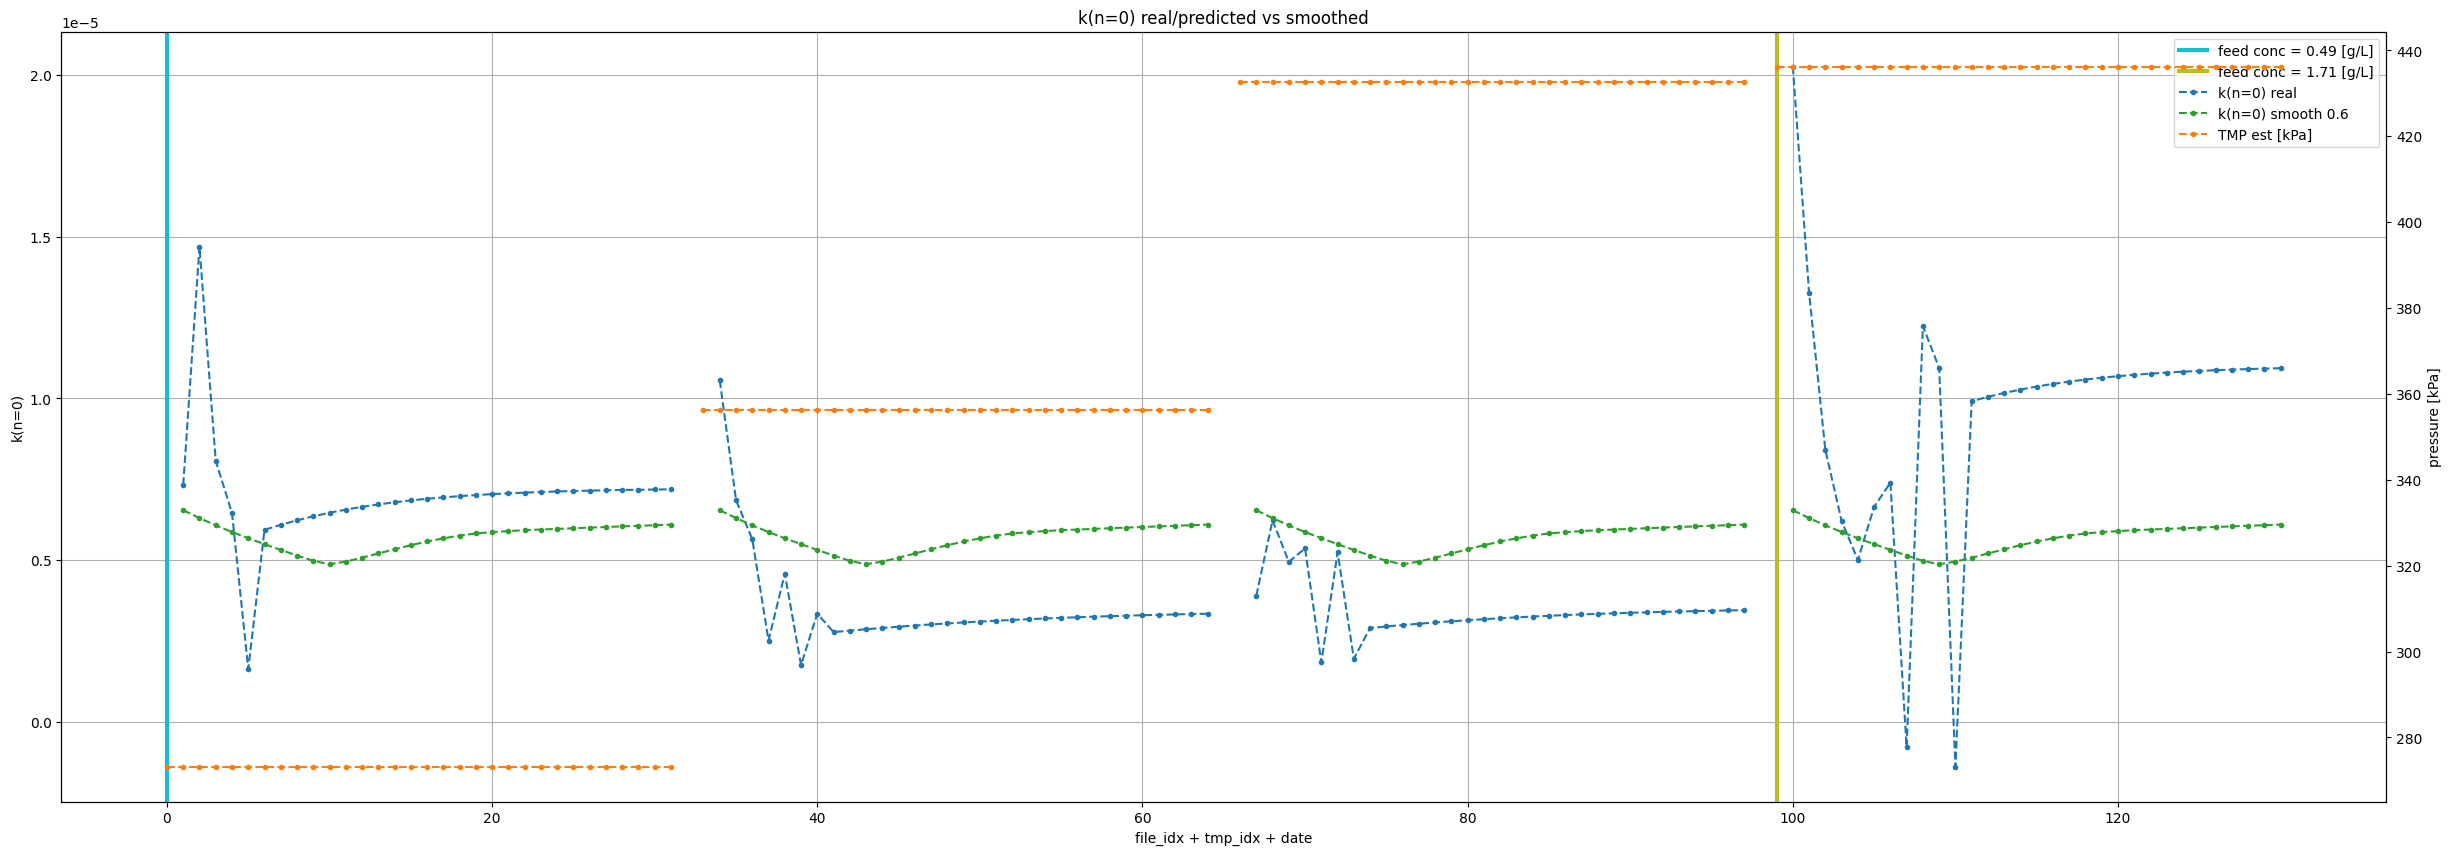

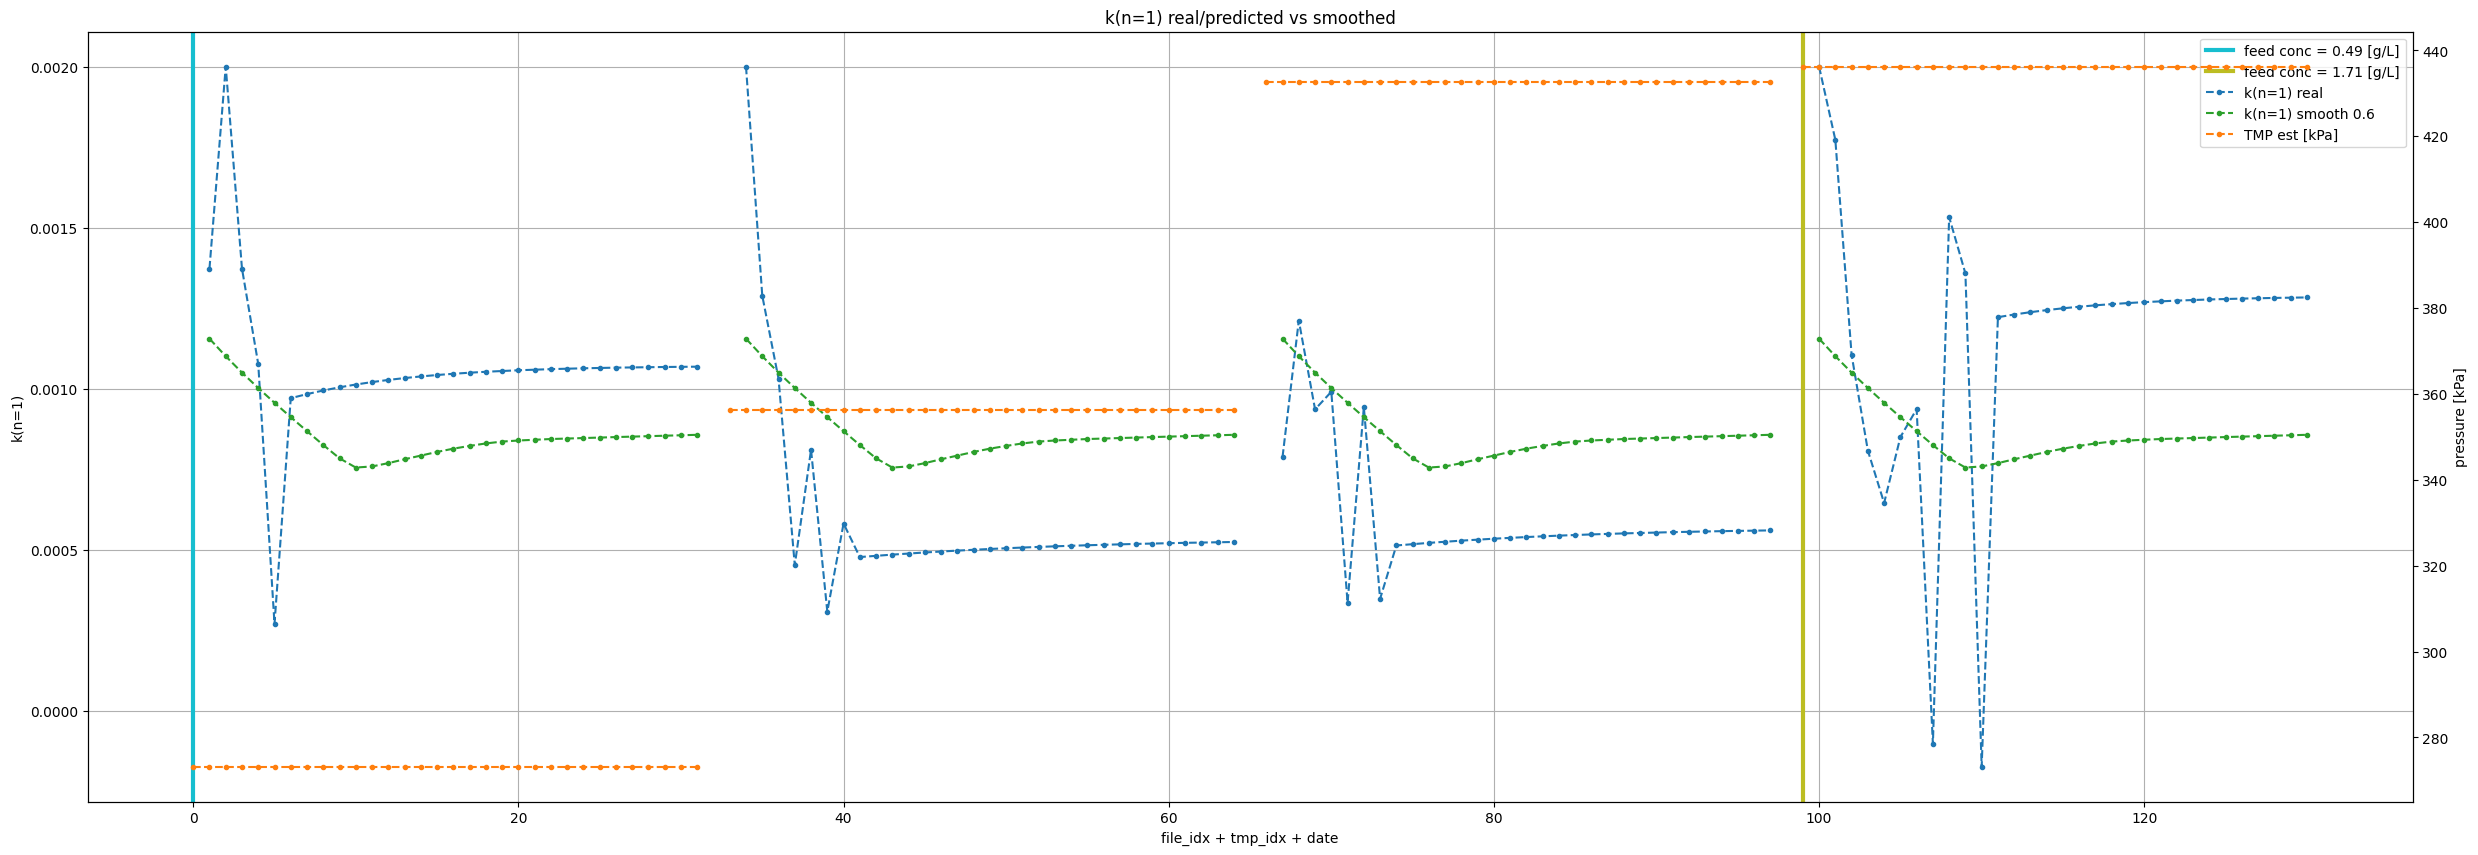

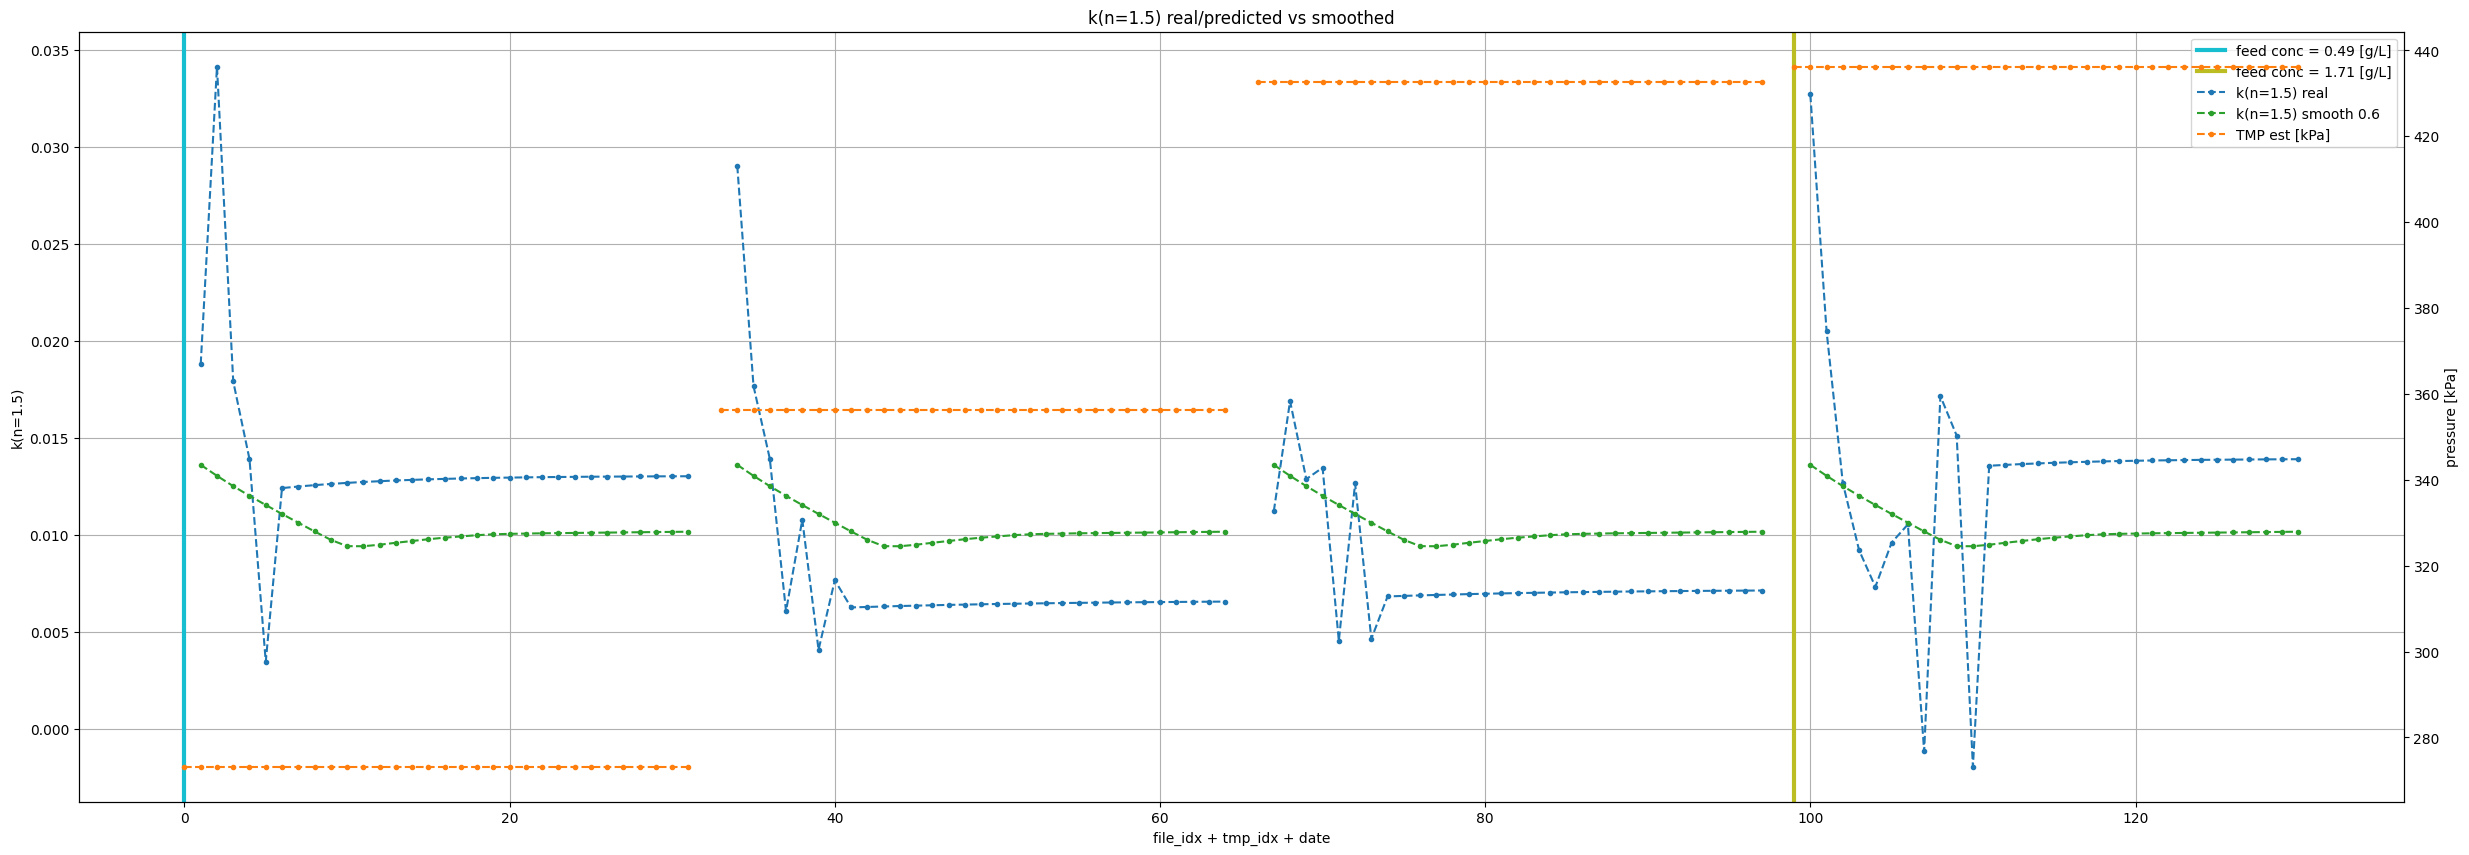

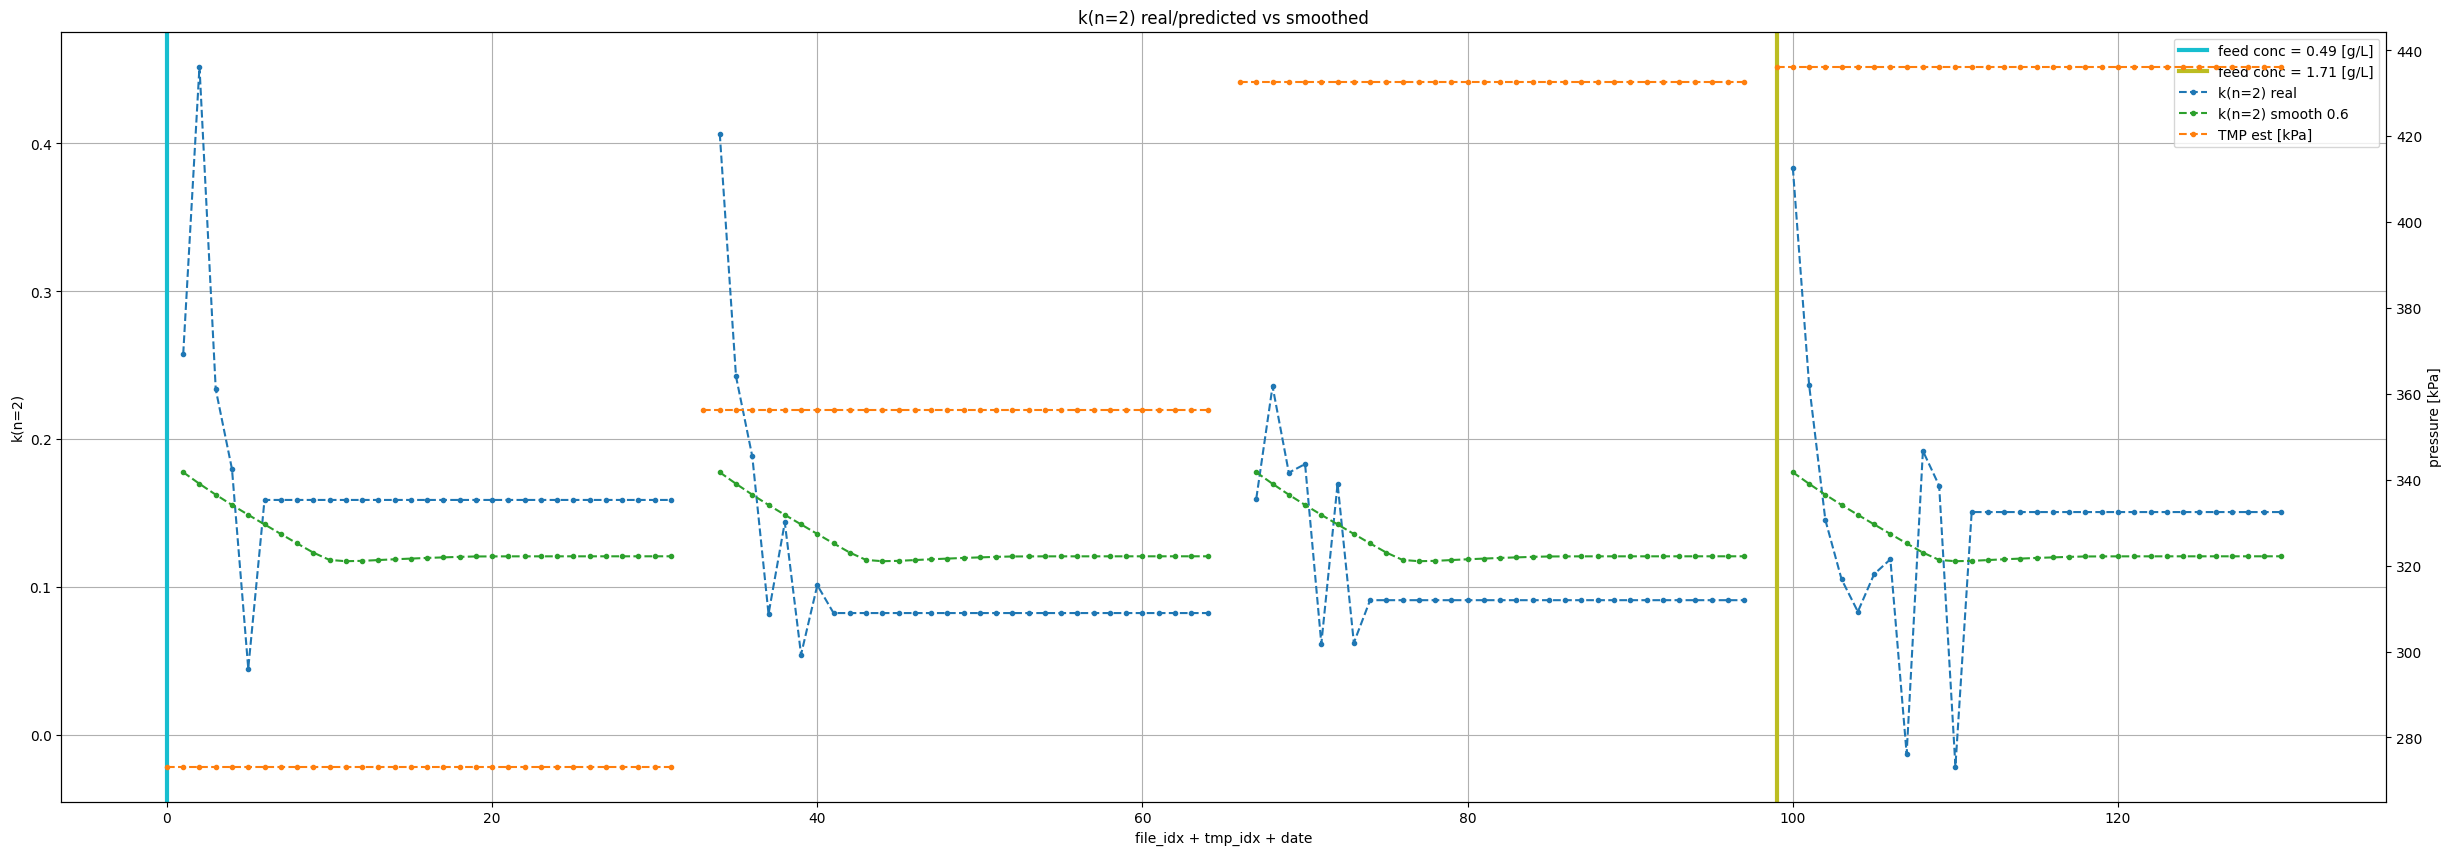

In [23]:
SMOOTHED_PARAMS = [0.6] #[0.2, 0.3, 0.4]
i = 0
for n in ALL_N :
    k_n = f'k(n={n})'
    #k_n_smooth = f'k(n={n}) smooth'
    MAX_K_N = ALL_MAX_K_N[i]
    #df[k_n] = df.apply(lambda x : max(-MAX_K_N, min(MAX_K_N, x[k_n])) if x[k_n] == x[k_n] else np.nan, axis = 1)
    y_dict = {
        f'{k_n} real' : df[k_n],
        #f'{k_n} real smoothed' : df[k_n_smooth],
        'TMP est [kPa]' : df['TMP est [kPa]']
    }
    for pct in SMOOTHED_PARAMS :
        col = f'{k_n} smooth {pct}'
        df[col] = smooth_data_lowess(df['time [m]'], df[k_n], pct=pct)
        y_dict[col] = df[col]
        #col = f'{k_n_smooth} smooth {pct}'
        #df[col] = smooth_data_lowess(df['time [m]'], df[k_n_smooth], pct=pct)
        #y_dict[col] = df[col]
    y_ax_lbl = [k_n, 'pressure [kPa]']
    title    = f'{k_n} real/predicted vs smoothed'
    plot_time_series_2_axis(x=df['index'], y_series=y_dict, x_ax_lbl='file_idx + tmp_idx + date', y_ax_lbl=y_ax_lbl, title=title, x_format=None, figsize=(30,10), secondary_y=['TMP est [kPa]'], concentration_lines=conc_lines)
    i += 1

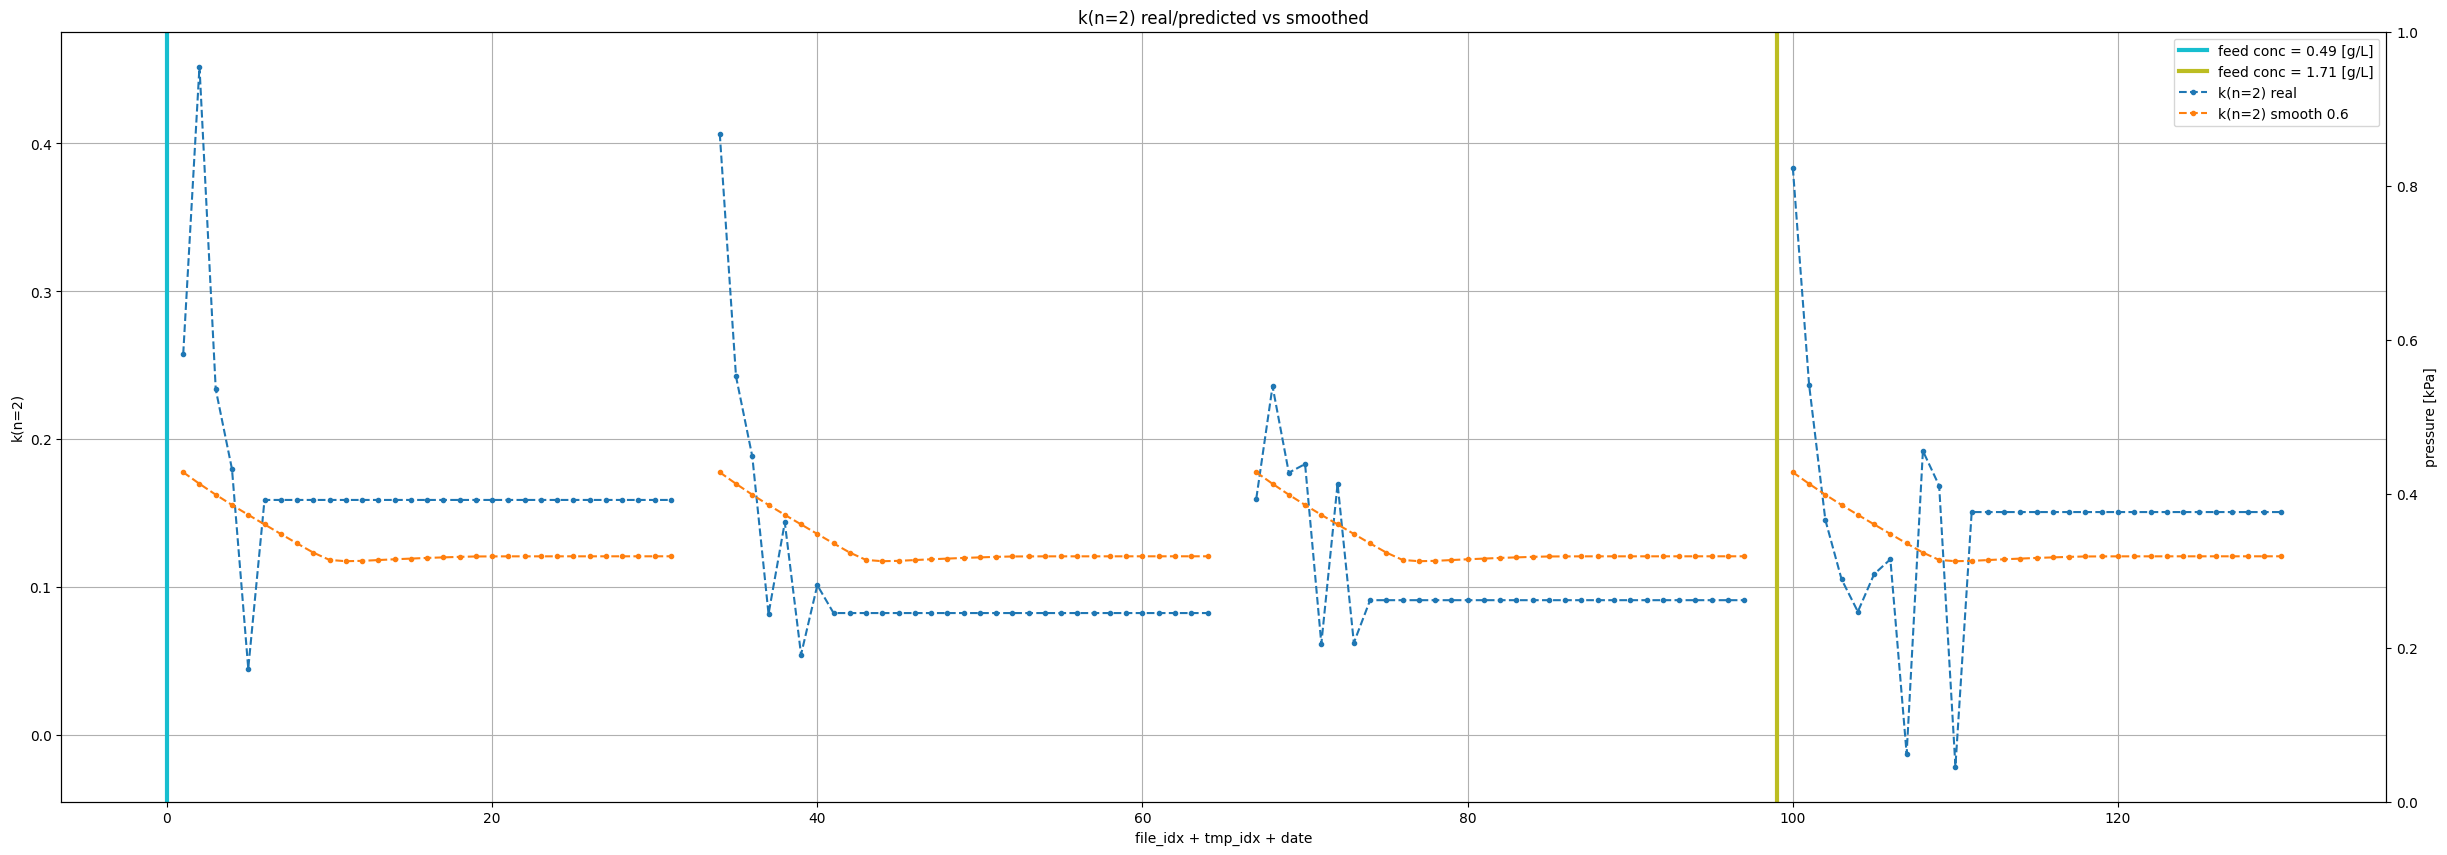

In [24]:
n = 2
k_n = f'k(n={n})'
y_dict = {
    f'{k_n} real' : df[k_n],
    #f'{k_n} real smoothed' : df[k_n_smooth],
}
for pct in SMOOTHED_PARAMS :
    col = f'{k_n} smooth {pct}'
    df[col] = smooth_data_lowess(df['time [m]'], df[k_n], pct=pct)
    y_dict[col] = df[col]
    #col = f'{k_n_smooth} smooth {pct}'
    #df[col] = smooth_data_lowess(df['time [m]'], df[k_n_smooth], pct=pct)
    #y_dict[col] = df[col]
y_ax_lbl = [k_n, 'pressure [kPa]']
title    = f'{k_n} real/predicted vs smoothed'
ax1, ax2 = plot_time_series_2_axis(x=df['index'], y_series=y_dict, x_ax_lbl='file_idx + tmp_idx + date', y_ax_lbl=y_ax_lbl, title=title, x_format=None, figsize=(30,10), secondary_y=['TMP est [kPa]'], concentration_lines=conc_lines)
#ax1.set_ylim((0,0.15))

(<Axes: xlabel='file_idx + tmp_idx + date', ylabel='k(n=2)'>,
 <Axes: title={'center': 'k(n=2) vs its factors'}, ylabel='factor [%]'>)

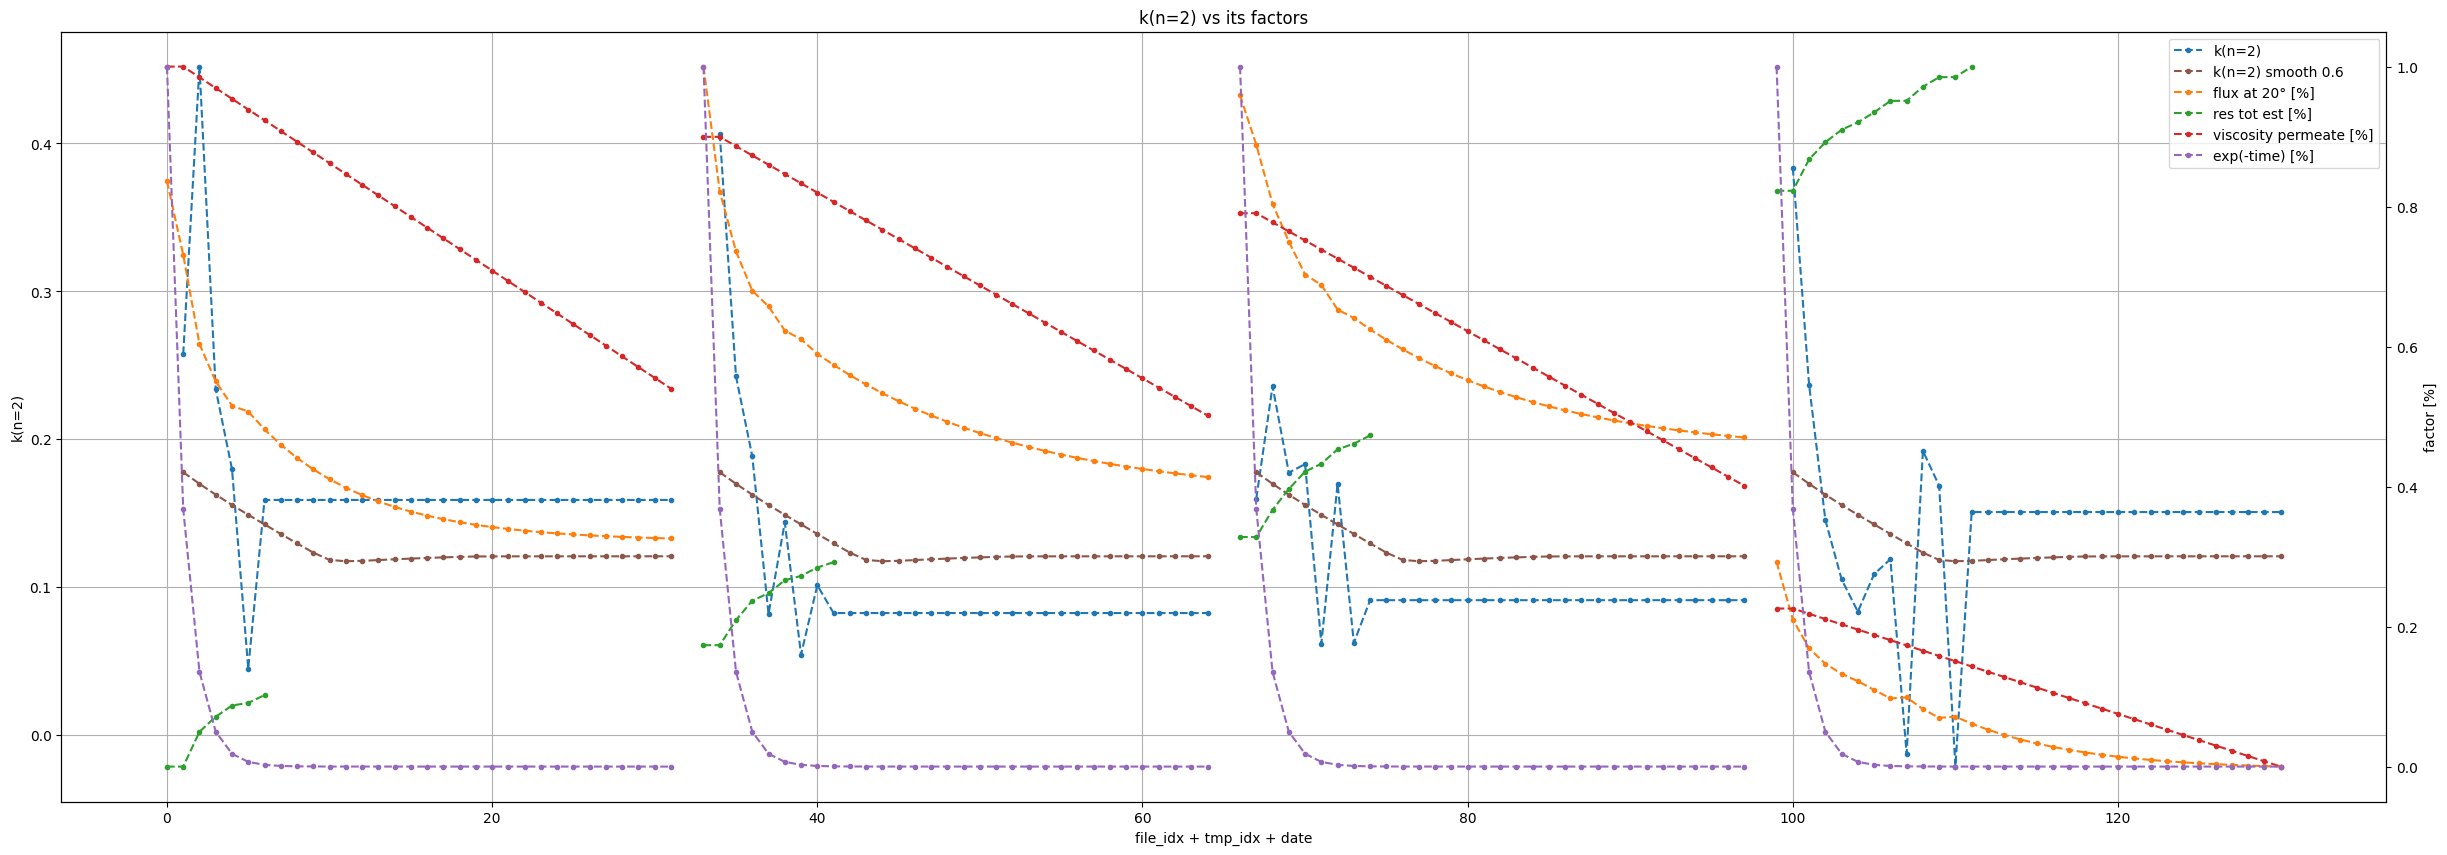

In [25]:
df['exp(-time) [m]'] = df['time [m]'].apply(lambda x : math.exp(-x))
df['exp(-time) [m]'] = df.apply(lambda x : np.nan if x['time [m]'] == MAX_TIME else x['exp(-time) [m]'], axis=1)

factors = [
    FLUX_COL, 'res tot est [1/m]', 'viscosity permeate [Pa s]', 'exp(-time) [m]', #'retentate concentration est [g/L]', 'permeate concentration est [g/L]' #'file_idx', 'tmp_idx'
]
y_ax_lbl = ['k(n=2)', 'factor [%]']
title    = 'k(n=2) vs its factors over time'
#plot_time_series_1_axis(x=df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=df['index'], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX])
# for file_idx in distinct(df['file_idx']) :
#     for tmp_idx in distinct(df['tmp_idx']) :
#         cur_df = df[(df['file_idx'] == file_idx) & (df['tmp_idx'] == tmp_idx)]
y_dict, lbls, y_ax_lbl, title = get_y_dict_min_max_cols(df, 'k(n=2)', factors)
#df['sigmoid TMP est [%]'] = df['TMP est [%]'].apply(lambda x : sigmoid(x))
#y_dict['sigmoid TMP est [%]'] = df['sigmoid TMP est [%]']
y_dict['k(n=2)'] = df['k(n=2)']
for pct in SMOOTHED_PARAMS :
    col = f'{k_n} smooth {pct}'
    y_dict[col] = df[col]
plot_time_series_2_axis(x=df['index'], y_series=y_dict, x_ax_lbl='file_idx + tmp_idx + date', y_ax_lbl=y_ax_lbl, title=title, x_format=None, secondary_y=lbls, loc='upper right', figsize=(30,10))

In [26]:
#TMP_LVL_COLS = [ c for c in df.columns if c[:9] == 'is TMP in']
#TMP_LVL_COLS

In [27]:
# df.columns


#############################################
method: Cake filtration
n: 0
Intercept:    5.652363805581794e-06
Coefficients: [2.7875410096847325e-06]
                            OLS Regression Results                            
Dep. Variable:      k(n=0) smooth 0.6   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     31.94
Date:                Fri, 14 Jun 2024   Prob (F-statistic):           1.06e-07
Time:                        17:01:46   Log-Likelihood:                 1659.3
No. Observations:                 124   AIC:                            -3315.
Df Residuals:                     122   BIC:                            -3309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t| 

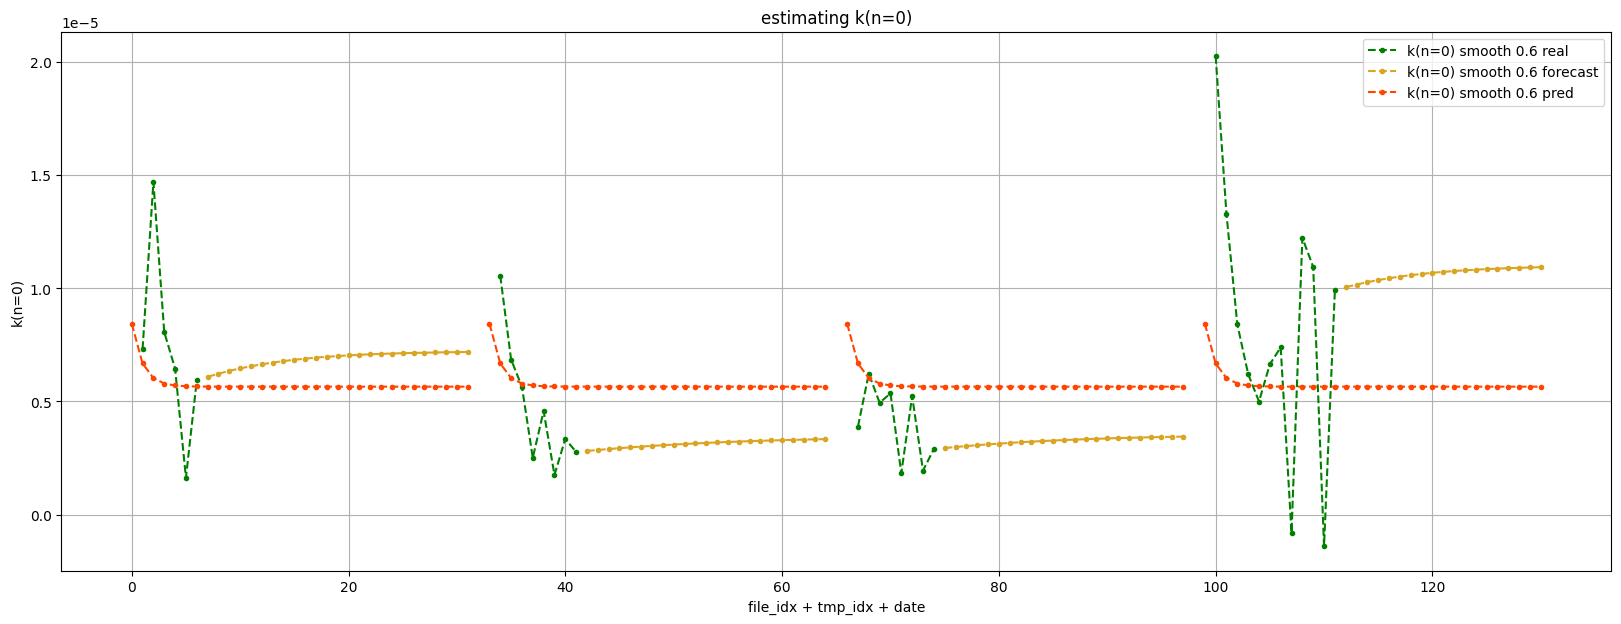

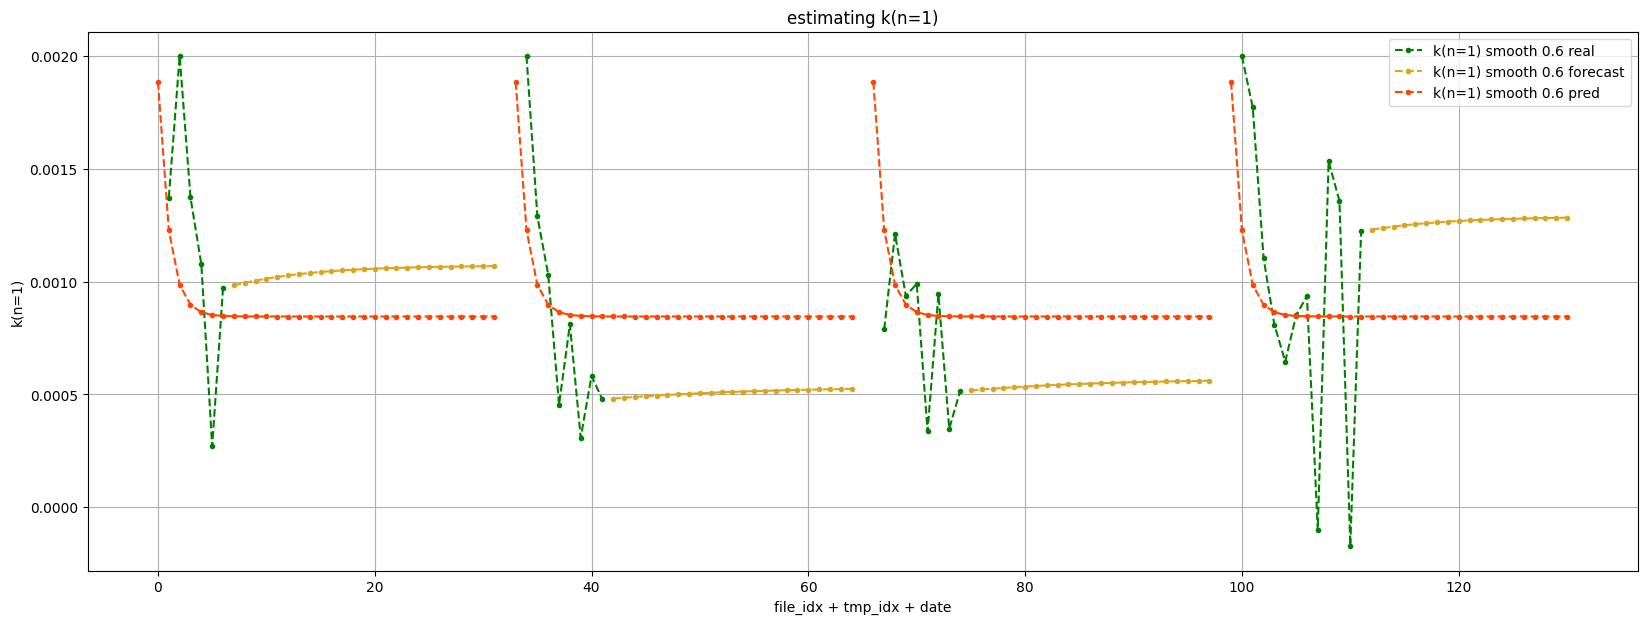

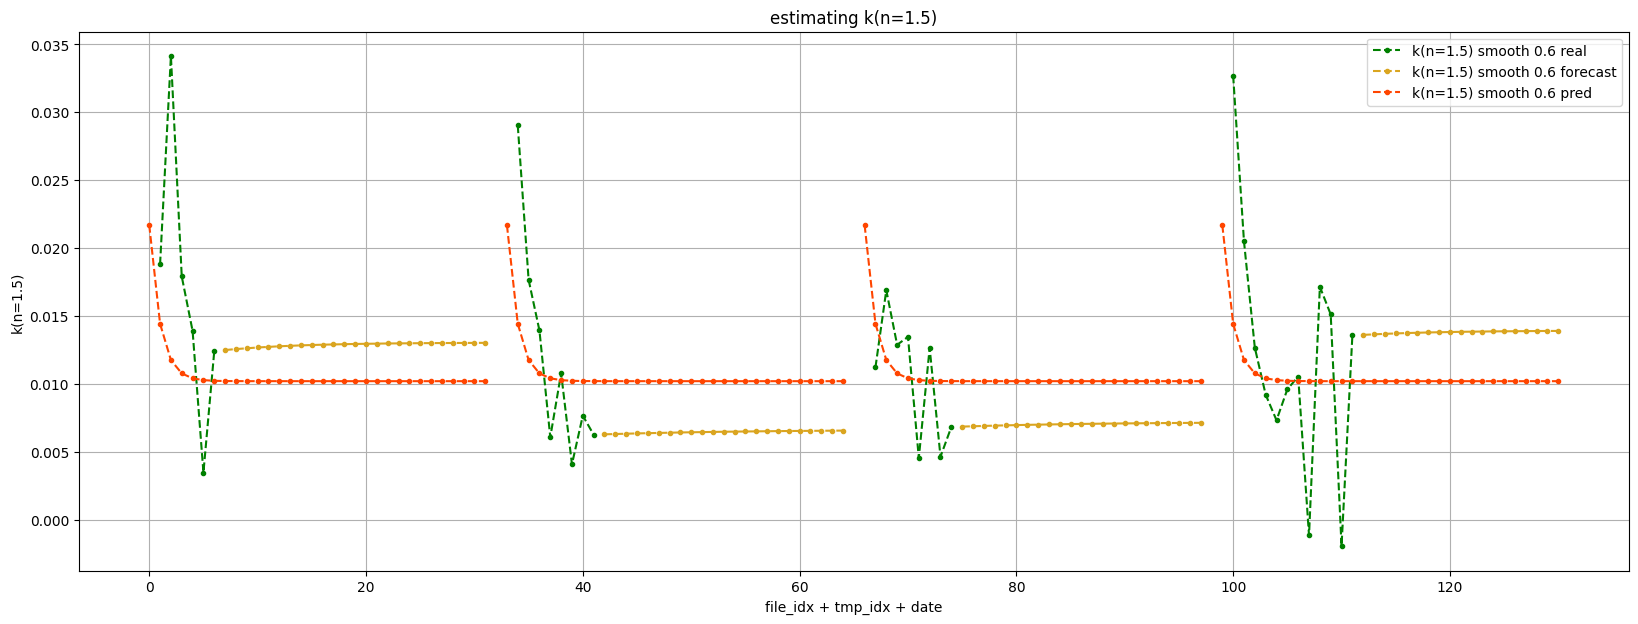

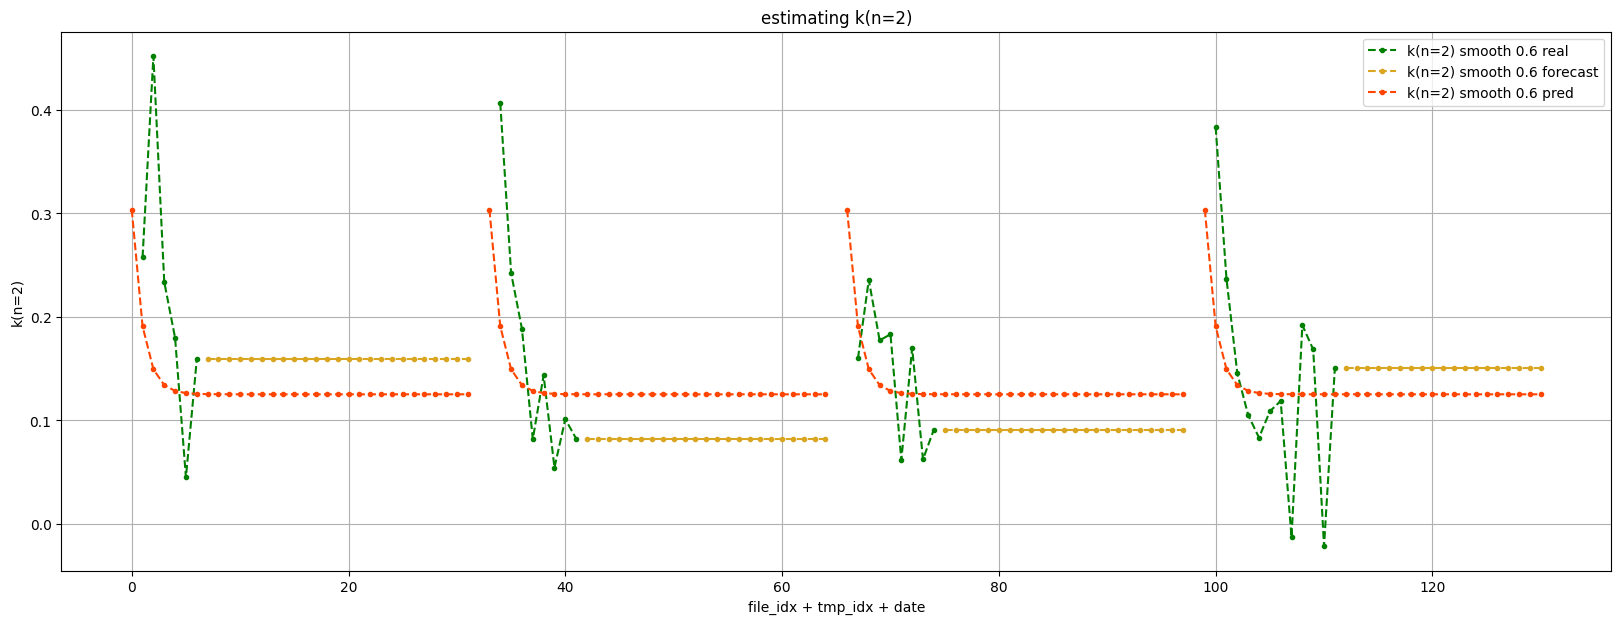

In [28]:
#df['is flux steady'] = df.apply(lambda x : abs(x['flux [L/m^2h]'] - x['flux min [L/m^2h]']) < 1, axis=1).astype(int)
#df['k(n=2)'] = df.apply(lambda x : max(-0.5, min(0.5, x['k(n=2)'])) if x['k(n=2)'] == x['k(n=2)'] else np.nan , axis = 1)
#df['k(n=2)'] = df.apply(lambda x : 0 if x['is flux steady'] == 1 else x['k(n=2)'], axis = 1)


# #df = df[df['time [m]'] < 15]

# c = 'permeate concentration est [g/L]'
# for i in range(len(df)) :
#     df.loc[i, f'initial {c}'] = df.loc[i, c] if (df.loc[i, 'time [m]'] == 0) else df.loc[i-1, f'initial {c}']

# df['f (permeate concentration est [g/L])'] = df['permeate concentration est [g/L]'].apply(lambda x : 1/(x+1))

#df['exp(-time**2) [m]'] = df['time [m]'].apply(lambda x : math.exp(-x**2))

#df['1 / (time [m] + 1)'] = df['time [m]'].apply(lambda x : (1/(x+1)))
#df['1 / (time [m]^2 + 1)'] = df['time [m]'].apply(lambda x : (1/(x**2+1)))

#df['is clear water'] = (df['initial feed concentration [g/L]'] == 0).astype(int)

df_k_n_pred = pd.DataFrame()
df_bckup = df
for n in ALL_N : 
    print("\n#############################################")
    print(f"method: {FOULING_NAME[n]}\nn: {n}")
    k_n = f'k(n={n})'
    k_n_smoothed = f'{k_n} smooth {SMOOTHED_PARAMS[0]}'
    x_cols = [ 
        #'initial feed concentration [g/L]',
        #'is TMP in [100, 200)',
        #'time [m]',
        'exp(-time) [m]',  
        #'res tot est [1/m]'
        #'is clear water'
        #'f(time)'
        #'exp(-time**2) [m]',
        #'1 / (time [m] + 1)',
        #'1 / (time [m]^2 + 1)',
    ]
    df = df[['time [m]', 'index', k_n, k_n_smoothed] + x_cols].dropna()
    y_col = k_n_smoothed #k_n
    x = df[x_cols]
    y = df[y_col] #df[k_n]
    model, y_pred, intercept, coeffs = call_linear_model(x, y, summary=True)
    print(f"\np-values:\n{model.pvalues}\n")
    print(get_error_stats(y, y_pred, y_col))
    print()
    compute_error_metrics(y, y_pred)

    y_pred = predict_y(df_bckup[x_cols], intercept, coeffs)
    #df[f'k(n={n}) pred'] = y_pred
    y_dict = {
        f'{y_col} real'        : df_bckup.apply(lambda x : np.nan if x['is forecast'] == 1 else x[k_n], axis=1),
        f'{y_col} forecast'    : df_bckup.apply(lambda x : np.nan if x['is forecast'] == 0 else x[k_n], axis=1),
        f'{y_col} pred'        : y_pred,
        #f'{y_col} smooth'             : df_bckup[k_n_smoothed], # NB uncomment color also
    }
    
    #for p in SMOOTHED_PARAMS :
    #    y_dict[f'y smooth p'] = df[f'{k_n} smooth {p}']
    #for c in [k_n, k_n_smoothed] :
    #    df[c] = df.apply(lambda x : np.nan if x['time [m]'] == MAX_TIME else x[c], axis=1)
    plot_time_series_1_axis(x=df_bckup['index'], y_series=y_dict, x_ax_lbl='file_idx + tmp_idx + date', y_ax_lbl=k_n, title=f'estimating {k_n}', x_format=x_format, color=['green', 'goldenrod', 'orangered']) #, 'pink'])
    df = df_bckup
    df_k_n_pred[f'{k_n} pred'] = y_pred[:MAX_TIME]
del(df_bckup)

In [29]:
df = df_dirty_water

In [30]:
n=2
k_n = f'k(n={n})'
k_n_pred = np.array(df_k_n_pred[f'{k_n} pred'])
flux_pred_lbl = f'flux pred {k_n}'
df[flux_pred_lbl] = np.nan
#cur_k_n_pred = cur_k_n_pred.reset_index(drop=True)
#j = np.nan
new_series = True
flux_min = np.nan
for i in range(len(df)) :
    cur_time = df.loc[i, 'time [m]'].astype(int)
    if new_series :
        flux_min = df.loc[i, f'{FLUX_USED} min [L/m^2h]']
        bef_flux = df.loc[i, FLUX_COL]
        df.loc[i, flux_pred_lbl] = bef_flux
        new_series = False
    elif pd.isna(df.loc[i, FLUX_COL]) :
        new_series = True
    else :
        #print(i, cur_time, df.loc[i, 'file_idx'], df.loc[i, 'tmp_idx'])
        # bef_flux = df.loc[i-1, flux_pred_lbl]
        # k = df.loc[i, k_n] #k = k_n_pred[j]
        k = k_n_pred[cur_time]
        k = 0 if pd.isna(k) else k
        k = 0 if pd.notna(k) and k < 0 else k
        if n == 2 :
            cur_flux = (bef_flux + k * flux_min) / (1+k)
        else :
            cur_flux = np.nan
        df.loc[i, flux_pred_lbl] = cur_flux
        #j += 1
        #bef_k = k / 1.5
        bef_flux = cur_flux            

In [31]:
df_frcst = df[df['is forecast'] == 1]
df_real  = df[(df['is forecast'] == 0)]
df_init = None
df_est = df
if INITIAL_ADDED :
    df_init = df_real[df_real['is initial'] == 1]
    df_real = df_real[df_real['is initial'] == 0]
    df_est  = df_est[df_est['is initial'] == 0]

   0: feed conc = 0.49 [g/L]
 198: feed conc = 1.30 [g/L]
 264: feed conc = 1.71 [g/L]


Text(0.5, 0, 'time [m]')

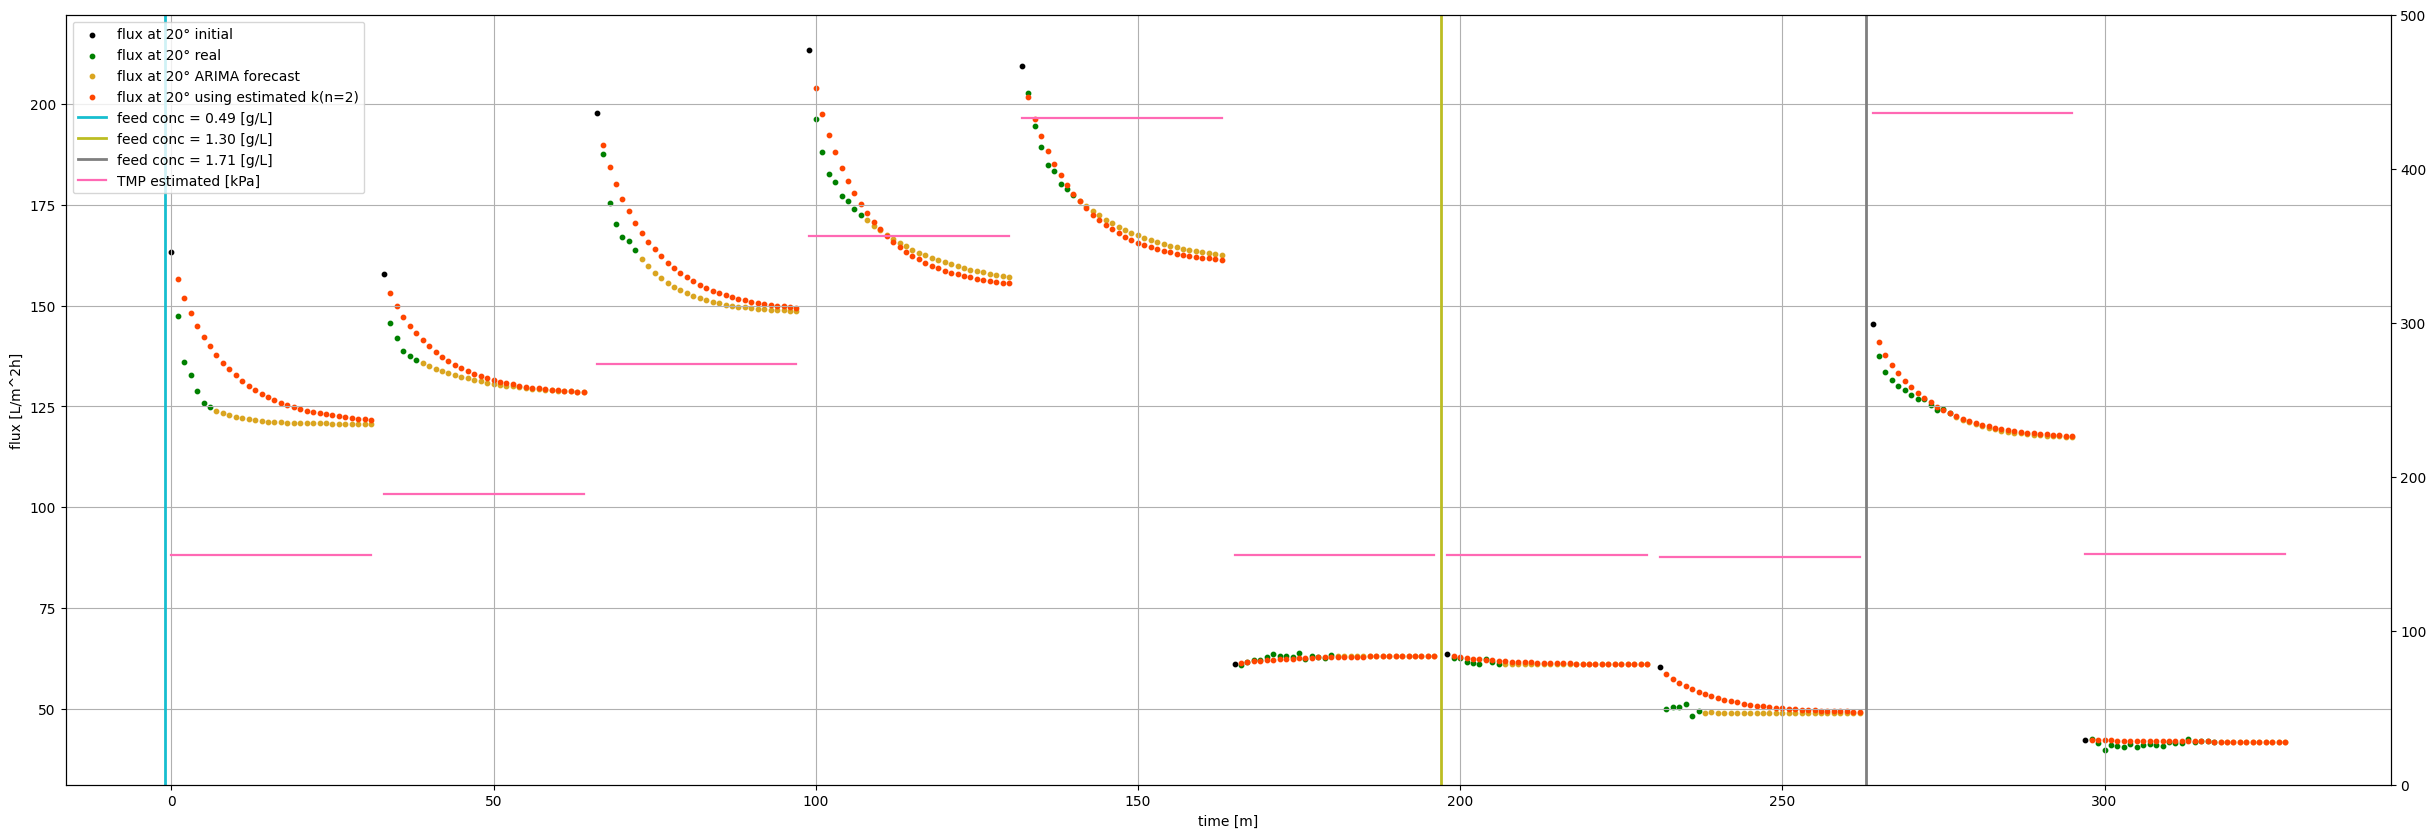

In [32]:
flux = FLUX_COL
# plot_time_series_1_axis(x=df_real['index'],  y_series={'flux real'    : df_real[flux]},            x_ax_lbl=df_real['index'],  y_ax_lbl=None,            title=None,                           color=['green'])
# plot_time_series_1_axis(x=df_frcst['index'], y_series={'flux forecast': df_frcst[flux]},           x_ax_lbl=df_frcst['index'], y_ax_lbl=None,            title=None,                           color=['gold'],  figsize=None)
# plot_time_series_1_axis(x=df['index'],       y_series={'flux pred using k(n=2)': df['flux pred']}, x_ax_lbl=df['index'],       y_ax_lbl='flux [L/m^2h]', title='Flux estimation given k(n=2)', color=['red'], figsize=None)

fig, ax1 = plot.subplots(figsize=(30,10))
ax2 = ax1.twinx()
# points
if INITIAL_ADDED :
    ax1.scatter(df_init['index'],  df_init[flux],  color='black', marker='o', s=10, label=f'{FLUX_USED} initial')
ax1.scatter(df_real['index'],  df_real[flux],                   color='green', marker='o', s=10, label=f'{FLUX_USED} real')
ax1.scatter(df_frcst['index'], df_frcst[flux],                  color='goldenrod',  marker='o', s=10, label=f'{FLUX_USED} ARIMA forecast')
ax1.scatter(df_est['index'],   df_est['flux pred k(n=2)'],          color='orangered',   marker='o', s=10, label=f'{FLUX_USED} using estimated k(n=2)')
# lines
#ax1.plot(   df['index'],       df[flux],                       color='black', marker='o', markersize=0, linestyle='--')
#ax1.plot(   df['index'],       df['flux pred k(n=2)'],         color='orangered',   marker='o', markersize=0, linestyle='--')
ax2.plot(   df['index'],       df['TMP est [kPa]'],            color='hotpink',   marker='o', markersize=0, lw=1.6, label='TMP estimated [kPa]')

conc_lines, conc_lines_GREATER_ZERO = get_concentration_lines(df, time_col='index')
i = len(COLOR_CYCLE) - 1
for (line_x,lbl) in conc_lines.items() :
    ax1.axvline(x=line_x-1, label=lbl, color=COLOR_CYCLE[i], linewidth=2)
    i -= 1

ax1.grid()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')
ax2.set_ylim((0,500))
ax1.set_ylabel('flux [L/m^2h]')
ax1.set_xlabel('time [m]')
#ax2.set_ylabel('pressure [kPa]')
#plot.savefig(f'{PATH_IMAGES}/linear_model_feed_pressure_2.png')

In [33]:
y_col = FLUX_COL
y = df[FLUX_COL].dropna()
y_pred = df['flux pred k(n=2)'].dropna()
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
print()

        flux at 20° [L/m^2h]  absolute error  relative error  squared error
min                39.858642        0.000000        0.000000       0.000000
median            121.117211        1.102998        0.009984       1.216626
mean              109.572105        2.148561        0.019688      13.819144
max               213.449219       16.505747        0.176079     272.439685
var              2420.669386        9.231679        0.000770    1470.034932
std                49.200299        3.038368        0.027748      38.341035

Error metrics:
R^2      0.9943
RMSE     3.7174
MAE      2.1486
MedAE    1.1030
maxAE   16.5057
MAPE     0.0197
maxAPE   0.1761


{'R^2': 0.9942732928902767,
 'RMSE': 3.7174109783584557,
 'MAE': 2.148560907932808,
 'MedAE': 1.102998266525205,
 'maxAE': 16.505747035983234,
 'MAPE': 0.019687665734334177,
 'maxAPE': 0.17607861915919176}

In [34]:
write_estimated_coefficients_to_json(FILE_EST_COEFFS, key='flux slope', x_cols=x_cols, intercept=intercept, coefficients=coeffs)